In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import tifffile 
from skimage.color import rgb2gray
from skimage import measure
import napari
from apoc import ObjectSegmenter, ObjectClassifier
import pyclesperanto_prototype as cle  # version 0.24.1
import numpy as np
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.6
import pandas as pd
from tqdm import tqdm
import os
import shutil

In [4]:
# Define the directory containing your files
directory_path = Path("./data/2X z-stacks/Full_plate")

# Initialize a dictionary to store the grouped (per well) files
images_per_well = {}

# Iterate through the files in the directory
for file_path in directory_path.glob('*.TIF'):
    # Get the filename without the extension
    filename = file_path.stem
    
    # Extract the last part of the filename (e.g., A06f00d0)
    last_part = filename.split('_')[-1]
    
    # Get the first three letters to create the group name (well_id)
    well_id = last_part[:3]
    
    # Check if the well_id exists in the dictionary, if not, create a new list
    if well_id not in images_per_well:
        images_per_well[well_id] = []
    
    # Append the file to the corresponding group
    images_per_well[well_id].append(str(file_path))

In [5]:
# This is just a check, it prints the grouped z-stacks
for well_id, files in images_per_well.items():
    print(f'Well {well_id}:')
    for file_path in files:
        print(file_path)

Well A01:
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z00_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z01_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z02_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z03_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z04_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z05_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z06_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z07_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z08_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z09_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z10_0_A01f00d0.TIF
Well A02:
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z00_0_A02f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z01_0_A02f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z02_0_A02f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_

In [6]:
# This will process all the images and extract the nr of organoids in focus from each image

nr_infocus_organoids = {}

for well_id in tqdm(images_per_well):
    
    imgs_to_process = images_per_well[well_id]
    
    for input_img in imgs_to_process:
        
        # Check if the well_id exists in the dictionary, if not, create a new list
        if well_id not in nr_infocus_organoids:
            nr_infocus_organoids[well_id] = []
            
        # Load one RGB image and transform it into grayscale for APOC
        rgb_img = tifffile.imread(input_img, is_ome = False)
        img = rgb2gray(rgb_img)

        # Apply object segmenter from APOC
        segmenter = ObjectSegmenter(opencl_filename="./ObjectSegmenter.cl")
        result = segmenter.predict(image=img)

        # Closing some holes in the organoid labels
        closed_labels = cle.closing_labels(result, None, radius=4.0)

        # Calculate and plot the area of each object to select a threshold to remove small objects
        # and keep just the organoids
        props = measure.regionprops(closed_labels) # Calculate the area of each labeled object

        # Exclude small labels, cutout in pixel area seems to be below 1000px
        exclude_small = cle.exclude_small_labels(closed_labels, None, 1000.0)
        exclude_small = np.array(exclude_small, dtype=np.int32) # Change dtype of closed labels to feed array into nsbatwm.split

        # Splitting organoids into a binary mask
        split_organoids = nsbatwm.split_touching_objects(exclude_small, sigma=10.0)

        # Connected component (cc) labeling
        cc_split_organoids = nsbatwm.connected_component_labeling(split_organoids, False)

        # Apply object classifier from APOC
        classifier = ObjectClassifier(opencl_filename="./ObjectClassifier.cl")
        result = classifier.predict(labels=cc_split_organoids, image=img)

        # Convert the resulting .cle image into a np.array to count objects within each class
        image_array = np.array(result, dtype=np.int8)
        
        # Create masks for each class
        background_mask = image_array == 0
        out_of_focus_mask = image_array == 1
        in_focus_mask = image_array == 2

        # Label connected components in each mask
        background_labels = measure.label(background_mask, connectivity=2)
        out_of_focus_labels = measure.label(out_of_focus_mask, connectivity=2)
        in_focus_labels = measure.label(in_focus_mask, connectivity=2)

        # Calculate the number of objects in each class
        num_background_objects = np.max(background_labels)
        num_out_of_focus_objects = np.max(out_of_focus_labels)
        num_in_focus_objects = np.max(in_focus_labels)

        #print(f"Number of Background Objects: {num_background_objects}")
        #print(f"Number of Out-of-Focus Objects: {num_out_of_focus_objects}")
        #print(f"Number of In-Focus Objects: {num_in_focus_objects}")

        in_focus_percentage = (num_in_focus_objects / (num_in_focus_objects + num_out_of_focus_objects)) * 100
        #print(f"Percentage of In-Focus Objects: {in_focus_percentage}")

        nr_infocus_organoids[well_id].append(in_focus_percentage)

100%|██████████| 24/24 [06:23<00:00, 15.96s/it]


In [7]:
# Create a Pandas DataFrame
df = pd.DataFrame(nr_infocus_organoids)

# Save the DataFrame as a .csv file
df.to_csv('./output/Percentage_in_focus_per_well.csv', index=False)

# Display the DataFrame
df

,A01,A02,A03,A04,A05,A06,B01,B02,B03,B04,...,C03,C04,C05,C06,D01,D02,D03,D04,D05,D06
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.597403,0.000000,0.000000,0.000000,0.000000,1.886792,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.234568,0.000000,0.000000,0.000000,0.000000,1.818182,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2.597403,0.000000,1.886792,2.173913,0.000000,3.846154,0.000000,0.000000,2.127660,2.500000,...,1.923077,1.388889,0.000000,1.666667,0.000000,0.000000,0.000000,5.555556,0.000000,3.448276
4,20.000000,9.523810,5.660377,10.869565,9.090909,32.075472,7.692308,0.000000,4.166667,9.756098,...,13.725490,9.589041,9.375000,11.475410,5.555556,10.909091,7.317073,13.157895,12.195122,22.033898
5,55.384615,45.312500,36.538462,37.777778,30.357143,62.962963,42.307692,13.333333,27.450980,34.146341,...,43.478261,43.835616,31.746032,49.152542,50.000000,41.379310,41.025641,40.000000,54.761905,55.737705
6,56.060606,46.031746,26.923077,30.434783,27.777778,50.000000,45.098039,32.608696,22.916667,35.897436,...,25.531915,29.577465,15.873016,33.333333,66.666667,56.896552,21.428571,32.500000,42.500000,38.709677
7,28.358209,34.375000,17.307692,21.739130,18.181818,35.714286,25.000000,25.531915,15.686275,19.512195,...,14.583333,8.219178,5.970149,9.523810,44.444444,20.338983,11.627907,2.564103,21.951220,16.666667
8,17.647059,26.984127,17.307692,16.000000,18.518519,18.181818,28.000000,25.000000,13.207547,10.810811,...,4.081633,2.857143,1.562500,5.084746,0.000000,10.526316,4.878049,0.000000,4.761905,3.333333
9,8.955224,14.516129,15.384615,6.521739,7.272727,17.307692,14.814815,11.627907,15.384615,2.777778,...,4.166667,1.408451,1.538462,1.639344,0.000000,4.918033,0.000000,0.000000,2.439024,0.000000


In [8]:
# Load the .csv and transform it into a dictionary again

# Load the CSV file into a DataFrame
df = pd.read_csv('./output/Percentage_in_focus_per_well.csv')

# Convert the DataFrame to a dictionary
nr_infocus_organoids = df.to_dict(orient='list')

In [9]:
# Finding the z-stack with the most organoids in-focus

max_index_dict = {}  # Create a new dictionary to store the maximum index for each key

for key, values in nr_infocus_organoids.items():
    max_value = max(values)  # Find the maximum value within the list
    max_index = values.index(max_value)  # Get the index of the maximum value
    max_index_dict[key] = max_index  # Store the index in the new dictionary

# Display the new dictionary
print(max_index_dict)
    

{'A01': 6, 'A02': 6, 'A03': 5, 'A04': 5, 'A05': 5, 'A06': 5, 'B01': 6, 'B02': 6, 'B03': 5, 'B04': 6, 'B05': 6, 'B06': 5, 'C01': 6, 'C02': 5, 'C03': 5, 'C04': 5, 'C05': 5, 'C06': 5, 'D01': 6, 'D02': 6, 'D03': 5, 'D04': 5, 'D05': 5, 'D06': 5}


In [10]:
# Storing a copy of each z-stack with the most organoids in focus

# Create a directory to store the tif files if it doesn't exist
output_dir = './output/in_focus_organoids'
os.makedirs(output_dir, exist_ok=True)

# Iterate through keys in max_index_dict
for key, index in max_index_dict.items():
    if key in images_per_well:
        file_paths = images_per_well[key]
        if 0 <= index < len(file_paths):
            file_path = file_paths[index]
            
            # Extract the file name (without the path)
            file_name = os.path.basename(file_path)
            
            # Construct the output file path
            output_path = os.path.join(output_dir, f"{key}.tif")

            # Copy the file using shutil.copy
            shutil.copy(file_path, output_path)

            print(f"Saved {key}.tif to {output_path}")
        else:
            print(f"Invalid index for key {key}: {index}")
    else:
        print(f"Key {key} not found in images_per_well dictionary")

Saved A01.tif to ./output/in_focus_organoids\A01.tif
Saved A02.tif to ./output/in_focus_organoids\A02.tif
Saved A03.tif to ./output/in_focus_organoids\A03.tif
Saved A04.tif to ./output/in_focus_organoids\A04.tif
Saved A05.tif to ./output/in_focus_organoids\A05.tif
Saved A06.tif to ./output/in_focus_organoids\A06.tif
Saved B01.tif to ./output/in_focus_organoids\B01.tif
Saved B02.tif to ./output/in_focus_organoids\B02.tif
Saved B03.tif to ./output/in_focus_organoids\B03.tif
Saved B04.tif to ./output/in_focus_organoids\B04.tif
Saved B05.tif to ./output/in_focus_organoids\B05.tif
Saved B06.tif to ./output/in_focus_organoids\B06.tif
Saved C01.tif to ./output/in_focus_organoids\C01.tif
Saved C02.tif to ./output/in_focus_organoids\C02.tif
Saved C03.tif to ./output/in_focus_organoids\C03.tif
Saved C04.tif to ./output/in_focus_organoids\C04.tif
Saved C05.tif to ./output/in_focus_organoids\C05.tif
Saved C06.tif to ./output/in_focus_organoids\C06.tif
Saved D01.tif to ./output/in_focus_organoids\D

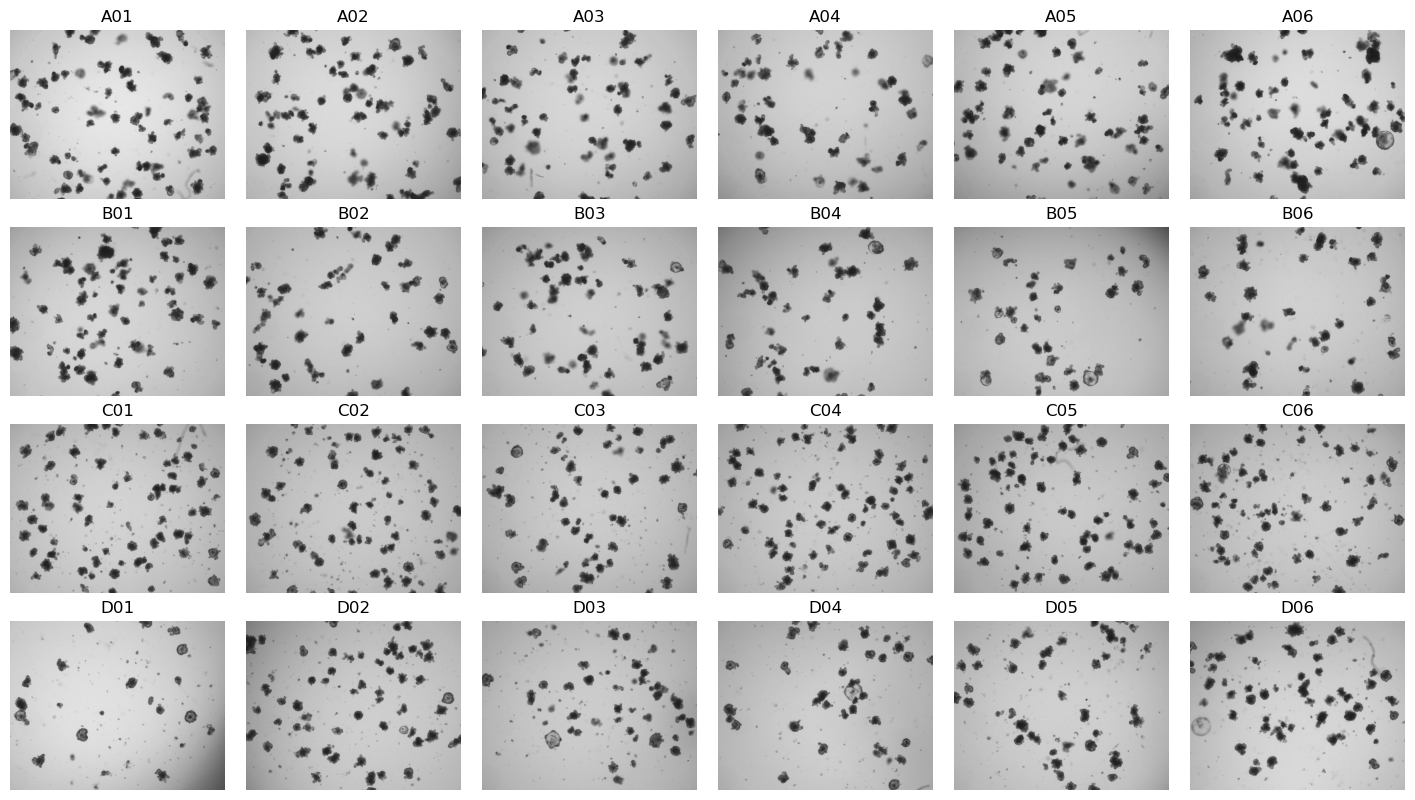

In [12]:
# Plot the images in a grid like fashion

# Path to the folder containing the images
folder_path = './output/in_focus_organoids/'

# Initialize a dictionary to store images by rows (letters)
image_dict = {}

# Iterate through the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.tif'):
        # Extract the first letter and the number from the filename
        first_letter = filename[0]
        number = int(filename[1:3])
        
        # Create a dictionary entry for the first letter if it doesn't exist
        if first_letter not in image_dict:
            image_dict[first_letter] = {}
        
        # Create a dictionary entry for the number if it doesn't exist
        if number not in image_dict[first_letter]:
            image_dict[first_letter][number] = []
        
        # Append the image filename to the corresponding number
        image_dict[first_letter][number].append(filename)

# Sort the dictionary by keys (letters) and nested dictionary by keys (numbers)
sorted_image_dict = {letter: dict(sorted(images.items())) for letter, images in sorted(image_dict.items())}

# Calculate the number of rows based on the number of letters
num_rows = len(sorted_image_dict)

# Calculate the number of columns based on the maximum number
num_cols = max(max(images.keys()) for images in sorted_image_dict.values())

# Calculate the figsize based on the number of columns and rows
fig_width = num_cols * 3  # Adjust the multiplier as needed
fig_height = num_rows * 2.5  # Adjust the multiplier as needed

# Create a subplot for each image, using None for empty subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharex=True, sharey=True)

for i, (letter, images) in enumerate(sorted_image_dict.items()):
    for j, (number, filenames) in enumerate(images.items()):
        if filenames:
            image_filename = filenames[0]  # Use the first filename in the list
            image_path = os.path.join(folder_path, image_filename)
            image = plt.imread(image_path)
            axes[i, j].imshow(image)
            axes[i, j].set_title(f'{letter}{number:02d}')
            axes[i, j].axis('off')
        else:
            # If there are no images for a specific letter-number combination, remove the empty subplot
            fig.delaxes(axes[i, j])

# Adjust the spacing and set aspect ratio to be equal
plt.subplots_adjust(wspace=0.1, hspace=0.1)  
for ax_row in axes:
    for ax in ax_row:
        ax.set_aspect('equal')

# Save the plot at a higher resolution
output_path = './output/output_plot.png'
plt.savefig(output_path, dpi=600, bbox_inches='tight')

# Show the plot (optional)
plt.show()